#### 基本設置 + 設cuda

In [13]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 48
num_classes = 2
learning_rate = 1e-5
num_epochs = 30

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### 讀取資料集

In [2]:
import numpy as np
# normalization
def CMVN(mfcc):
    mean = np.mean(mfcc, axis=0)
    std = np.std(mfcc, axis=0)
    # 進行均值和方差歸一化
    mfcc = (mfcc - mean) / (std + 1e-8) # avoid division by zero
    return mfcc

if __name__ == "__main__":
    # Example usage of CMVN
    mfcc_example = np.random.rand(13, 431)  # 假設有431個MFCC特徵，每個特徵有13個係數
    mfcc_normalized = CMVN(mfcc_example)
    print("Normalized MFCC shape:", mfcc_normalized.shape)
    print(mfcc_normalized-mfcc_example)

Normalized MFCC shape: (13, 431)
[[-1.07674333 -1.08608958 -1.01180241 ... -1.28080463 -2.14786939
   0.38756978]
 [-1.50448036 -0.58550118  0.21116491 ... -0.7085685  -1.54912448
  -0.34522359]
 [-0.54835623  0.43432727 -1.47542814 ...  0.09941305 -0.85750076
   0.04305208]
 ...
 [-0.04879432  0.22025698 -0.44561954 ... -1.22544342 -0.39909243
  -0.71427836]
 [-1.16583607 -0.55878745 -1.4746307  ... -1.39804507 -0.94237395
  -0.26228346]
 [ 0.62520429 -1.02851676 -0.07826509 ...  0.07295773 -0.5277449
  -1.26634797]]


In [3]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset

# 定义数据转换
transform = transforms.Compose([
    # transforms.Resize((480, 256)),  # fixed image dimension
    transforms.ToTensor(),           # make np to tensor
])

# dataset
class MFCC_Dataset(Dataset):
    def __init__(self, mfcc_folder, transform=None, normalization=False):
        self.mfccfolder = mfcc_folder
        self.mfccfile = os.listdir(mfcc_folder)
        self.transform = transform
        self.normalization = normalization
    def __len__(self):
        return len(self.mfccfile)
    def __getitem__(self, idx):
        mfcc_file = self.mfccfile[idx]
        # 範例：載入 precomputed mfcc tensor (n_mfcc, frame)
        filepath = os.path.join(self.mfccfolder, mfcc_file)
        mfcc = (np.load(filepath))  # or np.load -> torch.tensor
        # make into binary classificaton
        label = 0 if int(mfcc_file.split('_')[0]) < 5 else 1  # 假設標籤是文件名稱的一部分
        if self.normalization:
            mfcc = CMVN(mfcc)
        if self.transform:
            mfcc = self.transform(mfcc)
        return mfcc, label


# 獲取相關信息
source_folder = '../dataset/mfcc_features'
dataset = MFCC_Dataset(source_folder, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
# DataLoader for batching
for i, (mfcc, label) in enumerate(dataloader):
    # 在這裡進行訓練或驗證
    print(f"Batch {i}: MFCC shape: {mfcc.shape}, Label: {label}")
    break

Batch 0: MFCC shape: torch.Size([16, 1, 13, 431]), Label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])


Group-K fold cross validation

In [4]:
import numpy as np
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset, DataLoader

def create_group_kfold_loaders(dataset, batch_size, n_splits=5):
    """
    Split dataset using GroupKFold based on video names.
    Returns list of (train_loader, test_loader) tuples for each fold.
    """
    # Extract filenames to create groups
    mfcc_files = dataset.mfccfile
    filenames = []
    groups = []
    labels = []
    
    for file in mfcc_files:
        # Extract video name (assuming format: label_videoname_segment.npy)
        filename = file.split('_')[1]  # Get the video name part
        filenames.append(filename)
        labels.append(0 if int(file.split('_')[0]) < 5 else 1)
    
    # Convert filenames to group indices
    unique_filenames = list(set(filenames))
    groups = [unique_filenames.index(fname) for fname in filenames]
    
    # Create indices for GroupKFold
    indices = np.arange(len(dataset))
    
    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=n_splits)
    
    # Create loaders for each fold
    fold_loaders = []
    for fold_idx, (train_idx, test_idx) in enumerate(group_kfold.split(indices, labels, groups)):
        # Create subsets for train and test
        # select specific range of data
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)
        
        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
        
        fold_loaders.append((train_loader, test_loader, fold_idx))
    
    return fold_loaders

# Example usage
if __name__ == '__main__':
    fold_loaders = create_group_kfold_loaders(dataset, batch_size)
    
    # Now you can iterate through folds
    for train_loader, test_loader, fold_idx in fold_loaders:
        print(f"Fold {fold_idx}:")
        print(f"  Training samples: {len(train_loader.dataset)}")
        print(f"  Testing samples: {len(test_loader.dataset)}")

Fold 0:
  Training samples: 328
  Testing samples: 82
Fold 1:
  Training samples: 328
  Testing samples: 82
Fold 2:
  Training samples: 328
  Testing samples: 82
Fold 3:
  Training samples: 328
  Testing samples: 82
Fold 4:
  Training samples: 328
  Testing samples: 82


#### 創立model

In [5]:
import torch.nn.functional as F
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution , input_shape=(1,13,431)
        self.layer1 = self.input_processing_block(1, 16) #output_shape=(16,6,215)
        self.layer2 = self.conv_block(16, 8) #output_shape=(8,6,215)
        self.layer2_residue = self.residue_block(16, 8) #output_shape=(8,6,215)
        self.layer2_maxpool = nn.MaxPool2d(kernel_size=2) #output_shape=(8,3,107)

        # 🔑 用 dummy input 計算 flatten_size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 13, 431)
            out = self.layer1(dummy)
            conv_out = self.layer2(out)
            residual = self.layer2_residue(out)
            out = conv_out + residual
            out = self.layer2_maxpool(out)
            self.flatten_size = out.view(out.size(0), -1).shape[1]

        self.layer3 = self.classification_block(self.flatten_size, 512) #output_shape=(2,)

    def forward(self, x):
        # Convolutions
        out = self.layer1(x)
        
        # Apply residual connection
        conv_out = self.layer2(out)
        residual = self.layer2_residue(out)
        out = conv_out + residual  # Add the residual connection
        out = F.relu(out)  # Apply ReLU activation

        out = self.layer2_maxpool(out)
        out = self.layer3(out)

        return out
    
    def input_processing_block(self, in_channels, out_channels):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )
    def conv_block(self, in_channels, out_channels):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),    # expand the channels
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
    def residue_block(self, in_channels, out_channels):
        "By giving the parameters, the function will return a residual module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),    # expand the channels
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def classification_block(self, in_channels, out_channels):
        "By giving the parameters, the function will return a classification module"
        return nn.Sequential(
            nn.Dropout(0.3),  # dropout layer
            nn.Flatten(),  # flatten the output
            nn.Linear(in_channels, out_channels),  # fully connected layer
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(0.3),
            nn.Linear(out_channels, num_classes)  # final output layer
        )

In [6]:
import torchinfo

model = CNN_Model()
test_input = torch.randn(1, 1, 13, 431)  # Example input tensor
print(f"Model's structure:\n {torchinfo.summary(model, input_size=test_input.shape)}")

Model's structure:
Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model                                [1, 2]                    --
├─Sequential: 1-1                        [1, 16, 6, 215]           --
│    └─Conv2d: 2-1                       [1, 16, 13, 431]          416
│    └─ReLU: 2-2                         [1, 16, 13, 431]          --
│    └─BatchNorm2d: 2-3                  [1, 16, 13, 431]          32
│    └─MaxPool2d: 2-4                    [1, 16, 6, 215]           --
├─Sequential: 1-2                        [1, 8, 6, 215]            --
│    └─Conv2d: 2-5                       [1, 8, 6, 215]            136
│    └─ReLU: 2-6                         [1, 8, 6, 215]            --
│    └─BatchNorm2d: 2-7                  [1, 8, 6, 215]            16
│    └─Conv2d: 2-8                       [1, 8, 6, 215]            584
│    └─ReLU: 2-9                         [1, 8, 6, 215]            --
│    └─BatchNorm2d: 2-10                 [1, 8, 6, 215]        

#### 訓練模型

In [7]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [8]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def training(train_loader, test_loader, optimizer, num_epochs):
    # accumlated loss to visuallized
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    # Training
    model = CNN_Model().to(device)
    optimizer = optimizer
    criterion = nn.CrossEntropyLoss()
    
    # Example training loop (simplified)
    for epoch in range(1, num_epochs+1):
        # Train mode
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}/{num_epochs}")

        for iter, (input, target) in enumerate(train_bar):
            # Move data to "device".
            input = input.to(device)
            target = target.to(device)
            # Clear optimizer gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            output = model(input)
            # Compute the loss.
            loss = criterion(output, target)
            # Loss backward propagation.
            loss.backward()
            # Update all learnable parameters.
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            # predicted
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Update progress bar
            train_bar.set_description(f'Epoch: {epoch}/{num_epochs} | train loss: {train_loss / total:.4f} | train accuracy: {100 * correct / total:.2f}%')

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)  # Store average loss for visualization
        
        # Calculate average training accuracies
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)

        # Evaluate
        model.eval()
        BestValid = 0
        valid_loss = 0.0
        correct = 0
        total = 0
        
        valid_bar = tqdm(test_loader, desc=f"Validating Epoch {epoch}/{num_epochs}")
        with torch.no_grad():
            for inputs, targets in valid_bar:
                # run test
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs) # (batch_size, num_classes)
                # loss
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
                # predicted
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                # Update progress bar
                valid_bar.set_description(
                                            f"Epoch: {epoch}/{num_epochs} "
                                            f"| valid loss: {valid_loss / total:.4f} "
                                            f"| valid accuracy: {100 * correct / total:.2f}% "
                                        )
            
            if accuracy > BestValid:
                BestValid = accuracy
                BestValidModel = model

        # Calculate average validation loss and accuracy
        avg_valid_loss = valid_loss / len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(accuracy)

    return BestValidModel, train_losses, train_accuracies, valid_losses, valid_accuracies

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

In [10]:
import numpy as np
import os
labels = np.array([0 if int(label.split('_')[0]) < 5 else 1 for label in os.listdir(source_folder)])
weights = 1 / (num_classes * np.bincount(labels) / len(labels))  # Calculate class weights
print(weights)

[0.69727891 1.76724138]


Fold 0: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0174 | train accuracy: 48.17%: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s]
Epoch: 1/30 | valid loss: 0.0163 | valid accuracy: 68.29% : 100%|██████████| 2/2 [00:00<00:00, 32.49it/s]
Epoch: 2/30 | train loss: 0.0177 | train accuracy: 48.78%: 100%|██████████| 7/7 [00:00<00:00, 21.04it/s]
Epoch: 2/30 | valid loss: 0.0152 | valid accuracy: 82.93% : 100%|██████████| 2/2 [00:00<00:00, 30.50it/s]
Epoch: 3/30 | train loss: 0.0175 | train accuracy: 50.00%: 100%|██████████| 7/7 [00:00<00:00, 21.00it/s]
Epoch: 3/30 | valid loss: 0.0146 | valid accuracy: 90.24% : 100%|██████████| 2/2 [00:00<00:00, 26.90it/s]
Epoch: 4/30 | train loss: 0.0173 | train accuracy: 47.87%: 100%|██████████| 7/7 [00:00<00:00, 18.87it/s]
Epoch: 4/30 | valid loss: 0.0146 | valid accuracy: 82.93% : 100%|██████████| 2/2 [00:00<00:00, 29.06it/s]
Epoch: 5/30 | train loss: 0.0177 | train accuracy: 46.34%: 100%|██████████| 7/7 [00:00<00:00, 20.61it/s]
Epoch: 5/30 | valid loss: 0.0148 | valid accuracy: 



Fold 0 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.00       nan      0.00         0
           1       1.00      0.60      0.75        82

    accuracy                           0.60        82
   macro avg       0.50      0.60      0.37        82
weighted avg       1.00      0.60      0.75        82

Accuracy: 0.5976
Precision: 1.0000
Recall: 0.5976
F1 Score: 0.7481
ROC AUC Score: nan
Confusion Matrix:
[[ 0  0]
 [33 49]]


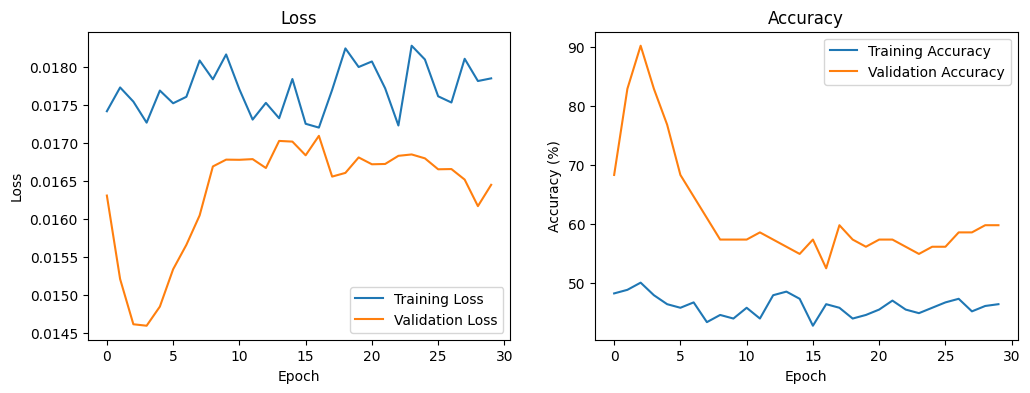

Fold 1: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0150 | train accuracy: 57.62%: 100%|██████████| 7/7 [00:00<00:00, 17.36it/s]
Epoch: 1/30 | valid loss: 0.0161 | valid accuracy: 64.63% : 100%|██████████| 2/2 [00:00<00:00, 24.29it/s]
Epoch: 2/30 | train loss: 0.0146 | train accuracy: 60.06%: 100%|██████████| 7/7 [00:00<00:00, 18.38it/s]
Epoch: 2/30 | valid loss: 0.0167 | valid accuracy: 57.32% : 100%|██████████| 2/2 [00:00<00:00, 26.60it/s]
Epoch: 3/30 | train loss: 0.0157 | train accuracy: 57.62%: 100%|██████████| 7/7 [00:00<00:00, 18.23it/s]
Epoch: 3/30 | valid loss: 0.0164 | valid accuracy: 59.76% : 100%|██████████| 2/2 [00:00<00:00, 26.73it/s]
Epoch: 4/30 | train loss: 0.0153 | train accuracy: 59.15%: 100%|██████████| 7/7 [00:00<00:00, 17.36it/s]
Epoch: 4/30 | valid loss: 0.0159 | valid accuracy: 64.63% : 100%|██████████| 2/2 [00:00<00:00, 28.40it/s]
Epoch: 5/30 | train loss: 0.0153 | train accuracy: 55.18%: 100%|██████████| 7/7 [00:00<00:00, 16.35it/s]
Epoch: 5/30 | valid loss: 0.0158 | valid accuracy: 



Fold 1 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77        75
           1       0.16      0.71      0.26         7

    accuracy                           0.65        82
   macro avg       0.56      0.68      0.51        82
weighted avg       0.89      0.65      0.72        82

Accuracy: 0.6463
Precision: 0.1562
Recall: 0.7143
F1 Score: 0.2564
ROC AUC Score: 0.7276
Confusion Matrix:
[[48 27]
 [ 2  5]]


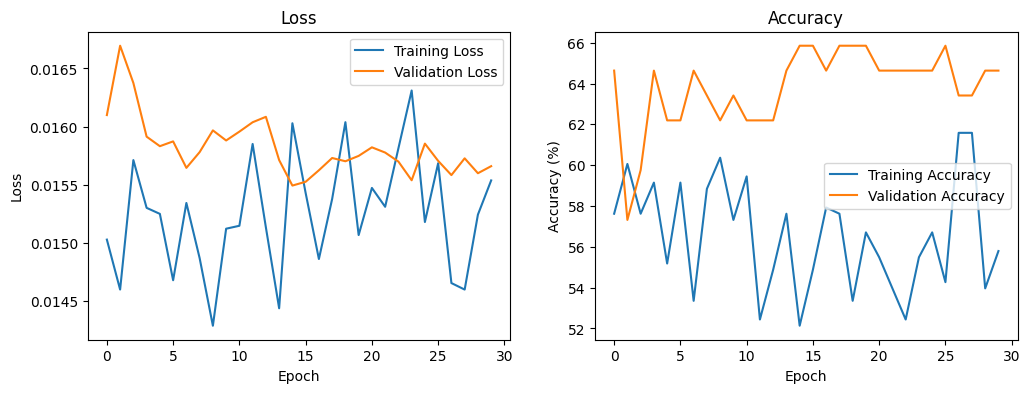

Fold 2: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0176 | train accuracy: 50.00%: 100%|██████████| 7/7 [00:00<00:00, 17.80it/s]
Epoch: 1/30 | valid loss: 0.0193 | valid accuracy: 25.61% : 100%|██████████| 2/2 [00:00<00:00, 23.87it/s]
Epoch: 2/30 | train loss: 0.0183 | train accuracy: 41.16%: 100%|██████████| 7/7 [00:00<00:00, 15.99it/s]
Epoch: 2/30 | valid loss: 0.0162 | valid accuracy: 70.73% : 100%|██████████| 2/2 [00:00<00:00, 22.26it/s]
Epoch: 3/30 | train loss: 0.0179 | train accuracy: 43.60%: 100%|██████████| 7/7 [00:00<00:00, 14.56it/s]
Epoch: 3/30 | valid loss: 0.0155 | valid accuracy: 76.83% : 100%|██████████| 2/2 [00:00<00:00, 20.25it/s]
Epoch: 4/30 | train loss: 0.0176 | train accuracy: 50.30%: 100%|██████████| 7/7 [00:00<00:00, 17.03it/s]
Epoch: 4/30 | valid loss: 0.0155 | valid accuracy: 78.05% : 100%|██████████| 2/2 [00:00<00:00, 24.44it/s]
Epoch: 5/30 | train loss: 0.0177 | train accuracy: 47.56%: 100%|██████████| 7/7 [00:00<00:00, 17.84it/s]
Epoch: 5/30 | valid loss: 0.0158 | valid accuracy: 



Fold 2 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73        73
           1       0.19      0.78      0.30         9

    accuracy                           0.61        82
   macro avg       0.57      0.68      0.52        82
weighted avg       0.87      0.61      0.68        82

Accuracy: 0.6098
Precision: 0.1892
Recall: 0.7778
F1 Score: 0.3043
ROC AUC Score: 0.7549
Confusion Matrix:
[[43 30]
 [ 2  7]]


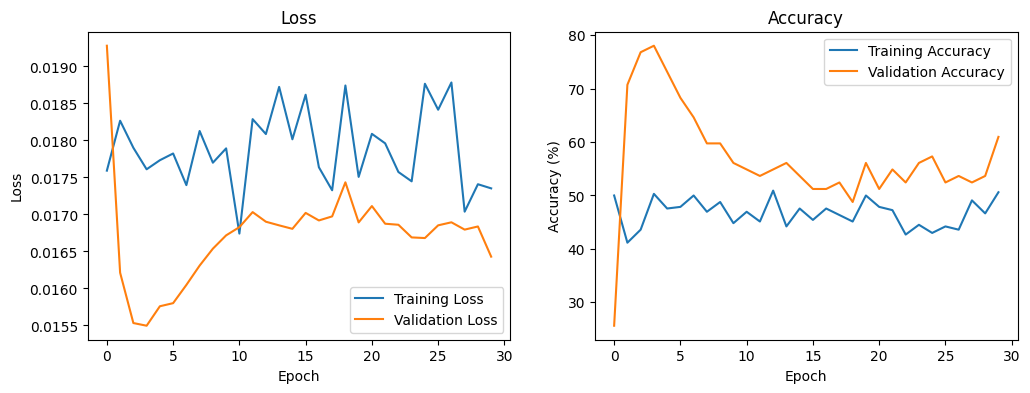

Fold 3: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0168 | train accuracy: 53.35%: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]
Epoch: 1/30 | valid loss: 0.0184 | valid accuracy: 34.15% : 100%|██████████| 2/2 [00:00<00:00, 27.01it/s]
Epoch: 2/30 | train loss: 0.0178 | train accuracy: 48.17%: 100%|██████████| 7/7 [00:00<00:00, 15.98it/s]
Epoch: 2/30 | valid loss: 0.0168 | valid accuracy: 62.20% : 100%|██████████| 2/2 [00:00<00:00, 20.83it/s]
Epoch: 3/30 | train loss: 0.0176 | train accuracy: 47.87%: 100%|██████████| 7/7 [00:00<00:00, 16.59it/s]
Epoch: 3/30 | valid loss: 0.0161 | valid accuracy: 70.73% : 100%|██████████| 2/2 [00:00<00:00, 22.56it/s]
Epoch: 4/30 | train loss: 0.0178 | train accuracy: 47.26%: 100%|██████████| 7/7 [00:01<00:00,  5.24it/s]
Epoch: 4/30 | valid loss: 0.0156 | valid accuracy: 69.51% : 100%|██████████| 2/2 [00:00<00:00, 35.33it/s]
Epoch: 5/30 | train loss: 0.0169 | train accuracy: 50.30%: 100%|██████████| 7/7 [00:00<00:00, 19.25it/s]
Epoch: 5/30 | valid loss: 0.0152 | valid accuracy: 



Fold 3 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.83        72
           1       0.07      0.10      0.08        10

    accuracy                           0.72        82
   macro avg       0.47      0.45      0.46        82
weighted avg       0.77      0.72      0.74        82

Accuracy: 0.7195
Precision: 0.0667
Recall: 0.1000
F1 Score: 0.0800
ROC AUC Score: 0.5583
Confusion Matrix:
[[58 14]
 [ 9  1]]


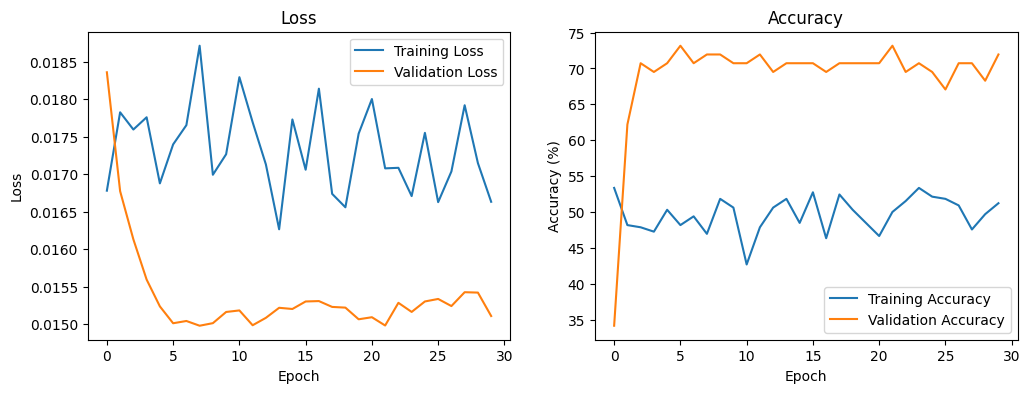

Fold 4: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.0154 | train accuracy: 57.62%: 100%|██████████| 7/7 [00:00<00:00, 17.45it/s]
Epoch: 1/30 | valid loss: 0.0206 | valid accuracy: 26.83% : 100%|██████████| 2/2 [00:00<00:00, 25.65it/s]
Epoch: 2/30 | train loss: 0.0161 | train accuracy: 56.10%: 100%|██████████| 7/7 [00:00<00:00, 16.71it/s]
Epoch: 2/30 | valid loss: 0.0197 | valid accuracy: 29.27% : 100%|██████████| 2/2 [00:00<00:00, 27.70it/s]
Epoch: 3/30 | train loss: 0.0159 | train accuracy: 53.35%: 100%|██████████| 7/7 [00:00<00:00, 17.76it/s]
Epoch: 3/30 | valid loss: 0.0193 | valid accuracy: 30.49% : 100%|██████████| 2/2 [00:00<00:00, 22.00it/s]
Epoch: 4/30 | train loss: 0.0157 | train accuracy: 56.40%: 100%|██████████| 7/7 [00:00<00:00, 16.83it/s]
Epoch: 4/30 | valid loss: 0.0187 | valid accuracy: 37.80% : 100%|██████████| 2/2 [00:00<00:00, 26.24it/s]
Epoch: 5/30 | train loss: 0.0158 | train accuracy: 54.57%: 100%|██████████| 7/7 [00:00<00:00, 17.27it/s]
Epoch: 5/30 | valid loss: 0.0183 | valid accuracy: 



Fold 4 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.51      0.67        74
           1       0.14      0.75      0.24         8

    accuracy                           0.54        82
   macro avg       0.55      0.63      0.45        82
weighted avg       0.87      0.54      0.63        82

Accuracy: 0.5366
Precision: 0.1429
Recall: 0.7500
F1 Score: 0.2400
ROC AUC Score: 0.6926
Confusion Matrix:
[[38 36]
 [ 2  6]]


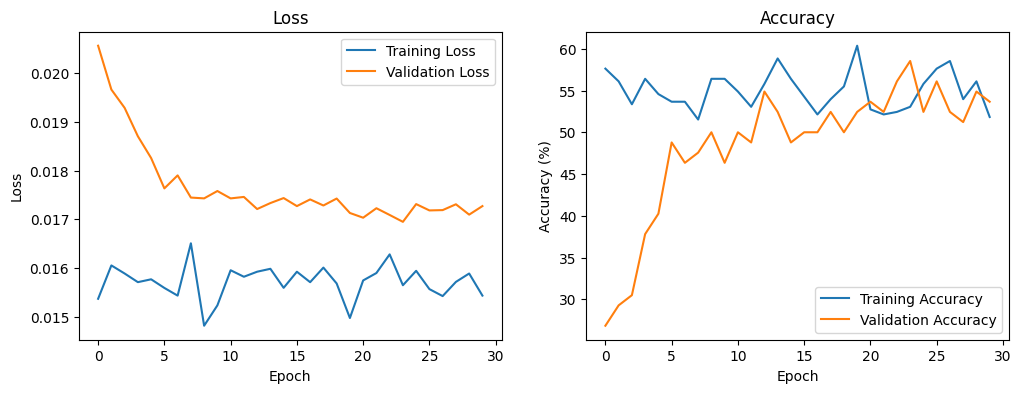

Best Validation Accuracy: 90.24% in Fold 0
Model saved to MFCCModel_classweight.pt


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# File name.
modelSaveName = "MFCCModel_classweight.pt"
# model
model = CNN_Model().to(device)
# Create an optimizer.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
# Create a loss function and Apply class weight imbalance
lossFunc = nn.CrossEntropyLoss(weight=torch.Tensor(weights))

BestValid_Acc = 0
Bestfold = 0
fold_loaders = create_group_kfold_loaders(dataset, batch_size)
for train, test, idx in fold_loaders:
    print(f"Fold {idx}: Training samples: {len(train.dataset)}, Testing samples: {len(test.dataset)}")
    model, train_losses, train_accuracies, valid_losses, valid_accuracies = training(train, test, optimizer, num_epochs)
    print()

    # Print statistics for this fold
    all_targets = []
    all_predictions = []
    all_probs = []
    
    # Set model to evaluation mode
    model.eval()
    
    # Collect predictions for test data
    with torch.no_grad():
        for inputs, targets in test:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Get probability scores for ROC AUC
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1]  # Probability for positive class
            
            # Store results for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs)
    
    # Calculate metrics
    try:
        roc_auc_score_value = roc_auc_score(all_targets, all_probs)
    except ValueError:
        # Handle case when only one class is present in targets
        roc_auc_score_value = 0.5
    
    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Print detailed metrics
    print(f"\nFold {idx} Test Results:")
    
    print(f"Classification Report:\n{classification_report(all_targets, all_predictions, zero_division=np.nan)}")
    print(f"Accuracy: {accuracy_score(all_targets, all_predictions):.4f}")
    print(f"Precision: {precision_score(all_targets, all_predictions):.4f}")
    print(f"Recall: {recall_score(all_targets, all_predictions):.4f}")
    print(f"F1 Score: {f1_score(all_targets, all_predictions):.4f}")
    print(f"ROC AUC Score: {roc_auc_score_value:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot the training history
    plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies)
    plt.show()

    # Check for best validation accuracy to store best model
    if max(valid_accuracies) > BestValid_Acc:
        BestValid_Acc = max(valid_accuracies)
        Bestfold = idx
        modelToSave = model


# 存檔
print(f"Best Validation Accuracy: {BestValid_Acc:.2f}% in Fold {Bestfold}")
torch.save(modelToSave.state_dict(), modelSaveName)
print('Model saved to %s' % modelSaveName)

測試模型
* inference time

In [15]:
import time
import torch
import numpy as np

# Load the model and move it to the device
model = CNN_Model().to(device)
model.load_state_dict(torch.load(modelSaveName))
model.eval()  # Set to evaluation mode

# Test data for inference
test_batch = next(iter(test_loader))[0].to(device)

# Warm-up runs
print("Warming up...")
with torch.no_grad():
    for _ in range(10):
        _ = model(test_batch)

# Measure inference time
print("Measuring inference time...")
n_iterations = 100
start_time = time.time()

with torch.no_grad():
    for _ in range(n_iterations):
        _ = model(test_batch)

end_time = time.time()

# Calculate statistics
total_time = end_time - start_time
avg_time_per_batch = total_time / n_iterations
avg_time_per_sample = total_time / (n_iterations * test_batch.size(0))

print(f"Total time for {n_iterations} iterations: {total_time:.4f} seconds")
print(f"Average time per batch: {avg_time_per_batch*1000:.2f} ms")
print(f"Average time per sample: {avg_time_per_sample*1000:.2f} ms")
print(f"Inference speed: {n_iterations * test_batch.size(0) / total_time:.2f} samples/second")

Warming up...
Measuring inference time...
Total time for 100 iterations: 0.5629 seconds
Average time per batch: 5.63 ms
Average time per sample: 0.35 ms
Inference speed: 2842.47 samples/second
